# 1. 연구 목표

- MNIST 손글씨 이미지 데이터를 사용
- 손글씨 이미지를 분류
- 알고리즘
    - 딥러닝의 CNN을 이용해서 손글씨를 예측하는 모델을 구축하겠다.
    - 예측 모델이 나오고 정확도를 평가하여 관찰
- 딥러닝 엔진 중 텐서플로우를 이용하여 구현한다.

# 2. 데이터 확보/수집

In [0]:
import tensorflow as tf
%tensorflow_version 1.x

In [0]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [86]:
type(mnist), len(mnist[0][0]), mnist[0][1], len(mnist[1][0]), mnist[1][1]

# 훈련용 데이터 : mnist[0][0]
# 훈련용 레이블 : mnist[0][1]
# 테스트용 데이터 : mnist[1][0]
# 테스트용 레이블 : mnist[1][1]
# 레이블 데이터는 벡터화가 안되어 있고, 분류형으로 0~9까지 배치되어 있다.

(tuple,
 60000,
 array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 10000,
 array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

In [87]:
# 레이블이 이미 벡터화 되어서 제공하는 tf의 데이터셋을 활용
# 단, 1.x에서만 사용 가능
from tensorflow.examples.tutorials.mnist import input_data 

mnist = input_data.read_data_sets('./data/mnist/', one_hot=True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [88]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [89]:
# 이미 데이터는 이미지 데이터는 28x28 픽셀로 처리되었고
# 레이블 데이터는 0~9를 0과 1로 구성하는 벡터화 처리(이진 데이터) 되어있다.
mnist.train.images.shape, mnist.train.labels.shape

((55000, 784), (55000, 10))

In [90]:
mnist.test.images.shape, mnist.test.labels.shape

((10000, 784), (10000, 10))

In [91]:
mnist.train.labels[:2]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [92]:
# 이미지 데이터는 float이다.
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 3. 데이터 준비

In [93]:
# 벡터화 된 레이블을 보고 원래값 0~9를 찾아내는 방법 확인
# 힌트 -> 배열 10칸 중에서 1이 존재하는 인덱스 값 -> 실제 수치값
import numpy as np

np.where(mnist.train.labels[:1][0])[0][0]

7

In [94]:
# 이미지 1개당 피쳐(feature)의 크기
pixels = mnist.train.images.shape[1]
pixels

784

In [95]:
# 레이블 1개당 피쳐(feature)의 크기
nums = mnist.train.labels.shape[1]
nums

10

In [96]:
# 이미지 가로 혹은 세로 크기(정사각형이므로 동일)
pixel_wh_size = int(np.sqrt(pixels))
pixel_wh_size

28

# 4. 데이터 분석(생략)

# 5. 모델 구축, 모델링

## 5-1. 데이터 플로우 그래프 구축
- 상수, 변수, 플레이스홀더, 연산 등의 요소를 레이어를 구축하면서 정의(define)
- Layer 구축 및 연결(원칙 : 앞단계의 출력이 뒷단계의 입력이다.)
    - 입력층
    - 합성곱층1
    - 풀링층1
    - 합성곱층2
    - 풀링층2
    - 전결합층
    - 드롭아웃층
    - 출력층

### 입력층

In [0]:
# x
# 손글씨 이미지 데이터가 들어오는 플레이스홀더
# 외부에서 학습 시 데이터가 주입된다.
# 이미지 1개를 표현하는 데 데이터가 784개의 feature가 필요
# 이런 이미지가 여러 개 주입될 수 있다. -> n개
# shape : (n, 784)
X = tf.placeholder(tf.float32, shape=(None, pixels), name='x')

### 합성곱층1

### W
- 가중치를 파라미터로 가지는 필터값 필요
- 행렬, 외부에서 주입(X), 내부적인 함수를 활용해서 생성한다. -> 텐서의 타입 중 Variable
- 2개의 합성곱층에서 W가 각각 필요하다. -> 2군데 이상 코드에서 W가 필요하다. -> W를 만드는 함수가 필요하다.

In [0]:
# 가중치를 초기화하고 W를 생성해서 리턴하는 함수를 구현
# shape : 가중치를 공용파라미터로 가지는 필터(= 커널)의 shape
#         커널의 크기가 무조건 3x3은 아니다.
# name : 각 구성원들의 이름을 구분하기 위해서 자동생성이 아닌 직접 부여
def makeWeightVariable(shape, name):
    
    # 변수의 초기값 -> 절단평균분포를 통한 난수를 발생하는 함수를 활용(설정)
    # shape이 크기에 맞춰서 배열을 만들고 함수가 계산해서 난수를 배치
    # stddev : 표준편차
    # shape 크기대로 난수가 배치되었다.(커널 크기만큼 행렬이 만들어지고 난수가 설정되었다.)
    w_initValue = tf.truncated_normal(shape, stddev=0.1)

    # 변수 생성
    w = tf.Variable(w_initValue, name='w_' + name)

    return w

In [0]:
# 바이어스(편향) 초기화 함수
# 변수로 정의하고 고정값(임계값으로 0.1)을 임시 부여
def makeBiasVariable(shape, name):
    b_initValue = tf.constant(0.1, shape=[shape])
    b = tf.Variable(b_initValue, name='b_' + name)
    
    return b

In [100]:
# 합성곱 계층을 만드는 함수
def makeConv2d(X, w):

    # 스트라이드는 고정해서 입력(설정)
    conv2d = tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], padding='SAME')
    
    return conv2d

'''
tf.nn.conv2d(
    input,              : X -> [batch(1회 훈련하고자 하는 이미지의 총 개수), in_height(세로크기), in_width(가로크기), in_channels(색에 따라 다름, 1 or 3)]
    
    filters,            : 필터 = 커널, 필터의 공용파라미터 -> 필터를 구성하는 구성원의 값 w 
                          [filter_height, filter_width, : 필터의 세로, 가로 크기 내맘대로 정한다.(상황고려)
                           in_channels  : 입력 채널 수 -> 1, 
                           out_channels : 출력 채널 수 -> 본인이 설정(몇 개의 이미지를 생성할 것인지)]

    strides,            : 정수값, 정수값의 리스트로만 구성, length 1, 2 or 4
                          [batch, width, height, depth]
                          통상적으로 batch, depth -> 1을 사용
                          width와 height는 일반적으로 같은값 부여
                          [1, 1, 1, 1] ->

    padding,            : 특성맵을 보정한다. 자르다보면 외곽선 부분에서 개수가 부족하게 나올 수도 있다.
                          이를 통상 0으로 테두리를 치면서 보정
                          SAME이란 값을 적용

    data_format='NHWC',
    dilations=None,
    name=None
)
'''

"\ntf.nn.conv2d(\n    input,              : X -> [batch(1회 훈련하고자 하는 이미지의 총 개수), in_height(세로크기), in_width(가로크기), in_channels(색에 따라 다름, 1 or 3)]\n    \n    filters,            : 필터 = 커널, 필터의 공용파라미터 -> 필터를 구성하는 구성원의 값 w \n                          [filter_height, filter_width, : 필터의 세로, 가로 크기 내맘대로 정한다.(상황고려)\n                           in_channels  : 입력 채널 수 -> 1, \n                           out_channels : 출력 채널 수 -> 본인이 설정(몇 개의 이미지를 생성할 것인지)]\n\n    strides,            : 정수값, 정수값의 리스트로만 구성, length 1, 2 or 4\n                          [batch, width, height, depth]\n                          통상적으로 batch, depth -> 1을 사용\n                          width와 height는 일반적으로 같은값 부여\n                          [1, 1, 1, 1] ->\n\n    padding,            : 특성맵을 보정한다. 자르다보면 외곽선 부분에서 개수가 부족하게 나올 수도 있다.\n                          이를 통상 0으로 테두리를 치면서 보정\n                          SAME이란 값을 적용\n\n    data_format='NHWC',\n    dilations=None,\n    name=None\n)\n"

In [0]:
# 합성곱층1 생성 : 텐서보드 상에 작업공간을 잡을려고
with tf.name_scope('conv1') as scope:
    
    # W
    # shape = [필터 세로크기, 필터 가로크기, 입력 채널 수, 출력 채널 수]
    # 설정값 : 5, 5, 32 -> 5x5 필터를 원본 이미지에서 스트라이드해서 나온 피처맵이 총 32개가 된다.
    w_conv1 = makeWeightVariable([5, 5, 1, 32], name='conv1')

    # b
    # 가중치 필터의 shape의 마지막 값과 편향의 shape 값은 동일하다.
    b_conv1 = makeBiasVariable(32, 'conv1')

    # x -> [batch, height, width, channels]
    # [None, 784] -> [batch, height, width, channels]
    # pixel_wh_size = 28(세로, 가로)
    X_image = tf.reshape(X, [-1, pixel_wh_size, pixel_wh_size, 1])

    # 컨볼루션 레이어 생성
    # 활성화 함수를 통과시켜서 레이어의 출력물(특성맵)을 비선형으로 보정 처리한다.
    # 이렇게 되면 '특성맵이 활성화맵으로 되었다' 라고 표현할 수 있다.
    h_conv1 = tf.nn.relu(makeConv2d(X_image, w_conv1) + b_conv1)

    # h_conv1은 합성곱층1의 출력물, 활성화맵, 다른 풀링층1의 입력 데이터가 된다.

In [102]:
h_conv1

# 합성곱층을 통과했을 때 특성맵의 크기는 원본과 같을수도(SAME), 다를 수도(VAILD) 있다.
# 크기를 결정하는 요인으로 -> stride, padding
# 합성곱의 핵심을 원본 이미지의 특성을 추출한 이미지가 출력 채널 수 만큼 생성된다는 점
# padding에 의해서 채워질 때, 원본과 동일한 사이즈로 가는가? 크기가 동일하다.
# padding을 SAME으로 하면 -> (?, 28, 28, 32)
# 유효한 부분만 가는가? 크기가 줄어든다.
# padding을 VALID로  하면 -> (?, 24, 24, 32) 

<tf.Tensor 'conv1_2/Relu:0' shape=(?, 28, 28, 32) dtype=float32>

In [103]:
h_conv1.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(32)])

### 풀링층1

- 특성맵(or 활성화맵)의 특성을 강화
- 최대풀링, 평균풀링, 최소풀링 등등 여러 개의 값 중 하나를 취해서 행렬을 새로 구성(축소)
- 샘플링한다 라고 표현
- 크기에 관여 -> 얼만큼 이동시키면서 처리할 것인가? -> stride, 커널에는 파라미터는 없고(최대, 평균, 최소 등 의미)
- 입력 : 이전 계층 합성곱층1의 결과물 -> h_conv1

In [104]:
def makeMaxPooling(X):
    return tf.nn.max_pool(value=X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

'''
tf.nn.max_pool(
    input,      : 이전 계층의 출력값, [batch, height, width, channels]
    ksize,      : 최대값 풀링을 수행하기 위한 슬라이딩 윈도우(= 커널, 필터)의 크기
                  [, height, width,]
    strides,    : ksize의 이동 보폭, 몇 칸씩 이동할 것인가
                  [batch, width, height, depth]
    padding,    : 보정, 크기가 안맞으면 SAME, ...
    data_format=None,
    name=None
)
'''

'\ntf.nn.max_pool(\n    input,      : 이전 계층의 출력값, [batch, height, width, channels]\n    ksize,      : 최대값 풀링을 수행하기 위한 슬라이딩 윈도우(= 커널, 필터)의 크기\n                  [, height, width,]\n    strides,    : ksize의 이동 보폭, 몇 칸씩 이동할 것인가\n                  [batch, width, height, depth]\n    padding,    : 보정, 크기가 안맞으면 SAME, ...\n    data_format=None,\n    name=None\n)\n'

In [0]:
# 풀링층1 생성
with tf.name_scope('pool1') as scope:
    h_pool1 = makeMaxPooling(h_conv1)

In [106]:
h_pool1

<tf.Tensor 'pool1_2/MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>

### 합성곱층2

In [0]:
# 레이어를 하나 더 쌓겠다.
with tf.name_scope('conv2') as scope:
    w_conv2 = makeWeightVariable([5, 5, 32, 64], name='conv2')
    b_conv2 = makeBiasVariable(64, 'conv2')
    h_conv2 = tf.nn.relu(makeConv2d(h_pool1, w_conv2) + b_conv2)

In [108]:
h_conv2

<tf.Tensor 'conv2_2/Relu:0' shape=(?, 14, 14, 64) dtype=float32>

### 풀링층2

In [0]:
with tf.name_scope('pool2') as scope:
    h_pool2 = makeMaxPooling(h_conv2)

In [110]:
h_pool2

<tf.Tensor 'pool2_2/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>

### 전결합층

- 원본 이미지는 풀링계층을 2번 통과하면서 그 크기가 : 28 / 2 / 2 = 7이 되었다.
- 전결합층에서는 출력층으로 가기 직전 단계로서 행렬 데이터를 Flatten(height, width, channel을 한 줄의 데이터로 펴준다. 동일사이즈 or 줄여서) 하는 것이 목적
- 최종 데이터는 [n, size(조정)]

In [0]:
with tf.name_scope('fully_connected') as scope:

    # 이미지 데이터 size -> n
    n = 7 * 7 * 64

    # 1024는 설정 : n(= 3136을 1024로 줄이는 느낌?)
    w_fc = makeWeightVariable([n, 1024], 'fc')
    b_fc = makeBiasVariable(1024, 'fc')
    
    # 이전 계층의 출력 데이터를 Flatten 처리 했다.
    h_pool2_flat = tf.reshape(h_pool2, [-1, n])

    h_fc = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc) + b_fc)

In [112]:
h_fc

<tf.Tensor 'fully_connected_2/Relu:0' shape=(?, 1024) dtype=float32>

### 드롭아웃층

- 과적합, 과잉적합, 오버핏 등을 방지
- 뉴런을 일부 죽여서 학습을 못하게 랜덤으로 처리
- 학습 데이터에 길들여지지 않게 처리하는 목적

In [0]:
with tf.name_scope('dropout1') as scope:
    keep_prob = tf.placeholder(tf.float32)

    h_fc_drop = tf.nn.dropout(h_fc, rate=1 - keep_prob)

In [114]:
h_fc_drop

<tf.Tensor 'dropout1_2/dropout/mul_1:0' shape=(?, 1024) dtype=float32>

### 출력층

- 이전 단계의 출력 데이터를 최종 레이블의 shape 형태로 맞춘다.
- 1024 -> 10으로 줄인다.
- 이 과정에 활성화 함수를 사용할 수 있다.
    - softmax 사용
        - 입력받은 값을 출력으로 0~1 사이값으로 사용
        - 모든 출력값은 0~1 사이로 정규화 처리
        - 그 값들의 총합은 1이 되는 함수 : 특정값을 확률적으로 표현할 수 있다.
        - 일반적인 뉴럴네트워크에서는 sigmoid를 사용한다.
        - 3가지 이상 범주형 분류를 하는 경우(다항 분류인 경우) softmax를 가장 많이 사용한다. 이것이 더 좋은 결과를 낸다.

In [0]:
with tf.name_scope('output') as scope:
    w_out = makeWeightVariable([1024, 10], 'output')
    b_out = makeBiasVariable(10, 'output')
    y_conv = tf.nn.softmax(tf.matmul(h_fc_drop, w_out) + b_out)

In [116]:
y_conv

<tf.Tensor 'output_2/Softmax:0' shape=(?, 10) dtype=float32>

In [0]:
# 이후 실행에 필요한 정답 벡터가 들어갈 플레이스홀더 요소 준비
y_ = tf.placeholder(tf.float32, shape=(None, nums), name='y_')

## 5-2. 실행(학습, 예측, 평가)
- 데이터를 준비(batch 사이즈, ...) -> 학습 -> 예측 -> 평가(출력)

### 크로스 엔트로피, 손실

- 비용(cost), 손실(loss) : 이런 지표는 원하는 결과에서 얼마나 떨어져 있는지 보여주는 지표
- 이 값(격차)을 줄이는 방향으로 전개

In [0]:
with tf.name_scope('loss') as scope:
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))

### 경사 하강법

- 크로스 엔트로피의 값(손실함수의 값)을 작아지도록 점차적으로 반복적으로 이동시켜서 변경하는 방식
- 확률적 경사하강법
    - 무작위로 초기화 한 매개변수를 손실함수 값이 작아지도록 지속적/반복적으로 변경 처리를 수행

In [0]:
with tf.name_scope('sgd') as scope:
    
    # 1e-4 : 설정값
    optimizer = tf.train.AdamOptimizer(1e-4)
    train_step = optimizer.minimize(cross_entropy)

### 예측, 평가

In [0]:
with tf.name_scope('predict') as scope:
    predict_step = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy_step = tf.reduce_mean(tf.cast(predict_step, tf.float32))

### 주입할 데이터 함수 정의

- 실행 시 주입할 데이터를 편하게 구성
- 반복 학습이 수행되므로 주입 데이터는 간편하게 구성해야 한다.
- 데이터 플로우 그래프 전체에서 placeholder를 다 찾아서 명시하면 된다.
- {<br>
    &nbsp;&nbsp; x: <br>
    &nbsp;&nbsp; y_: <br> 
    &nbsp;&nbsp; keep_prob: <br>
}

In [0]:
def makeFeedDict(images, labels, prob):
    return {X: images, y_: labels, keep_prob: prob}

### 실행

In [134]:
TRAIN_COUNT = 3000      # 학습 총 횟수(설정)

step_list = list()
acc_list = list()
loss_list = list()

with tf.Session() as sess:
    
    # 1. 텐서플로우 변수 초기화
    sess.run(tf.global_variables_initializer())

    # 2. 테스트용으로 사용할 주입 데이터 준비
    test_fd = makeFeedDict(mnist.test.images, mnist.test.labels, 1)
    
    # 3. 반복 학습
    for step in range(TRAIN_COUNT):

        # 3-1. batch 사이즈(1회 훈련 시 사용되는 데이터의 총량, gpu 사용 시 메모리 계산) 기준으로 훈련 데이터 준비
        batch = mnist.train.next_batch(50)      # 50개씩 데이터를 사용
    
        # 차후에는 직접 데이터를 뽑아서 훈련시킨다.
        # 3-2. 훈련용 주입 데이터 준비
        train_fd = makeFeedDict(batch[0], batch[1], 0.5)

        # 3-3. 훈련(데이터 주입)
        _, loss = sess.run([train_step, cross_entropy], feed_dict=train_fd)

        # 3-4. 특정 횟수 마다 로그 출력
        if step % 100 == 0:
            acc = sess.run(accuracy_step, feed_dict=test_fd)
            print('%s %s %s' % (step, acc, loss))

            step_list.append(step)
            acc_list.append(acc)
            loss_list.append(loss)
    
    # 4. 최종 결과 출력
    f_acc = sess.run(accuracy_step, feed_dict=test_fd)
    print('최종 정답률 :', f_acc)

    step_list.append(step)
    acc_list.append(acc)
    loss_list.append(loss)

    # 5. 텐서보드 기록

    pass

0 0.0863 585.6687
100 0.8457 88.23404
200 0.9046 22.555233
300 0.9304 23.144827
400 0.9429 19.66103
500 0.9409 17.477188
600 0.9543 13.722801
700 0.9567 20.210308
800 0.9642 9.657501
900 0.963 12.600226
1000 0.9675 3.979366
1100 0.9664 5.3348417
1200 0.9718 5.1024218
1300 0.9698 4.989645
1400 0.972 15.027338
1500 0.9736 14.594105
1600 0.9756 3.0515385
1700 0.9772 7.7881937
1800 0.9759 15.164886
1900 0.9776 11.850855
2000 0.9787 7.5610247
2100 0.98 7.0626345
2200 0.9793 6.0152698
2300 0.9799 4.4088287
2400 0.9811 3.3982155
2500 0.982 6.071024
2600 0.9809 8.626655
2700 0.9819 3.362978
2800 0.9815 1.1593796
2900 0.9811 3.52812
최종 정답률 : 0.9833


[8, 84, 90, 93, 94, 94, 95, 95, 96, 96, 96, 96, 97, 96, 97, 97, 97, 97, 97, 97, 97, 98, 97, 97, 98, 98, 98, 98, 98, 98, 98]


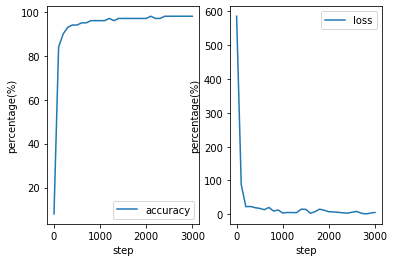

In [135]:
from matplotlib import pyplot as plt
%matplotlib inline

acc_list = list(map(lambda x: int(x * 100), acc_list))

# accuracy 시각화
plt.subplot(1, 2, 1)
plt.plot(step_list, acc_list)
plt.xlabel('step')
plt.ylabel('percentage(%)')
plt.legend(['accuracy'])

# loss 시각화
plt.subplot(1, 2, 2)
plt.plot(step_list, loss_list)
plt.xlabel('step')
plt.ylabel('percentage(%)')
plt.legend(['loss'])

plt.show()

# 6. 시스템 통합(생략)